In [17]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu
import statsmodels.stats.multitest

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling, stats
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

# Load in the data and filter to Pearson correlation

In [7]:
data_path = "/Users/abry4213/data/HCP100/"

# Load in all the pyspi homotopic res
all_homotopic_res = pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*.csv")])
pearson_homotopic_res = all_homotopic_res.query("SPI=='cov_EmpiricalCovariance' & base_region_from == base_region_to")

# Compute the mean value for each base_region_to in pearson_homotopic_res
pearson_homotopic_res_mean = (pearson_homotopic_res
                                  .groupby(['Subject', 'base_region_to', 'SPI'])['value'].mean().reset_index()
                                  .groupby("base_region_to")['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"base_region_to": "Base_Region",
                                                   "value": "Mean_Pearson_R"}))

pearson_homotopic_res_for_dk = (pearson_homotopic_res
                                  .groupby(["base_region_to", 'hemi_from'])['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"value": "Mean_Pearson_R"})
                                    )

## Visualize the mean Pearson FC from L--R and R--L in the brain (averaged across hemispheres, first)

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


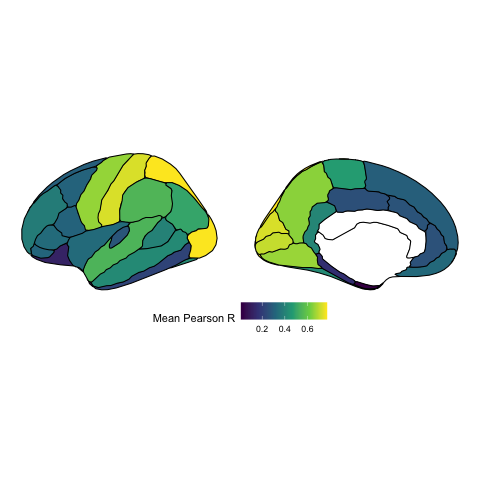

In [8]:
%%R -i pearson_homotopic_res_mean

### Pearson FC in brain ###
pearson_homotopic_res_mean %>%
  ungroup() %>%
  mutate(label = glue("lh_{Base_Region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = Mean_Pearson_R),
        position = "stacked", colour = "black", hemisphere="left",
        linewidth=0.5) +
  theme_void() +
  labs(fill = "Mean Pearson R") +
  theme(plot.title = element_blank(),
        legend.position = "bottom") +
  scale_fill_viridis_c(na.value = "white")
# ggsave("../plots/measure_maps/Mean_LR_averaged_Pearson_R_ggseg.svg", width = 4, height = 3)

## Plot the overall distribution of Pearson R in each brain region, using a raincloud plot

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


`summarise()` has grouped output by 'Subject'. You can override using the
`.groups` argument.


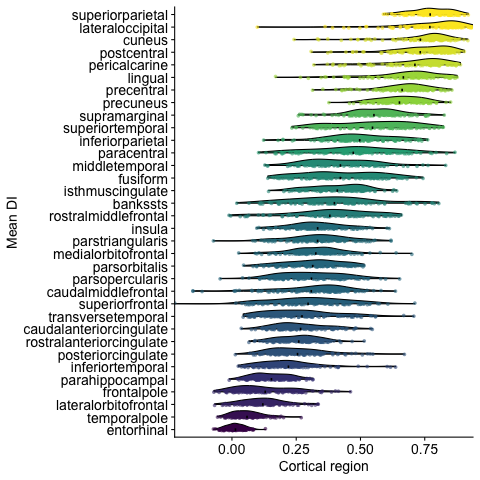

In [9]:
%%R -i pearson_homotopic_res

pearson_homotopic_res %>%
  group_by(Subject, base_region_to) %>%
  summarise(Mean_Pearson_R = mean(value, na.rm=T)) %>%
  ungroup() %>%
  group_by(base_region_to) %>%
  mutate(mean_region_Pearson_R = mean(Mean_Pearson_R)) %>%
  ungroup() %>%
  mutate(base_region_to = fct_reorder(base_region_to, Mean_Pearson_R, .fun=mean)) %>%
  ggplot(data=., mapping=aes(x=base_region_to, y=Mean_Pearson_R, fill=mean_region_Pearson_R)) +
  geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
  geom_point(aes(color = mean_region_Pearson_R), position = position_jitter(width = 0.075, height=0),
                          size = 1.75, alpha=0.6, stroke=0) +
  stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
          show.legend=FALSE, position = position_dodge(width=1.4))+
  xlab("Mean DI") +
  ylab("Cortical region") +
  scale_y_continuous(expand=c(0,0)) +
  scale_fill_viridis_c(na.value = "white") +
  scale_color_viridis_c(na.value = "white") +
  coord_flip() +
  theme(legend.position="none",
        axis.text = element_text(size=14)) 
# ggsave("../plots/measure_maps/Subject_wise_LR_averaged_Pearson_R_violins.svg", width=6, height=8, dpi=300, units="in")

## Compare region-wise hierarchy values with Pearson-based homotopic connectivity (HoFC)

In [11]:
# Read in brain region lookup table
brain_region_info = pd.read_csv("../data/Brain_Region_Info.csv")

# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

if not os.path.exists("../data/hierarchy_dk_neuromaps_res.csv"):
    nm_atlas_df = pd.read_csv('hierarchy_neuromaps_atlases.csv')

    # Convert the DK atlas to gifti format
    dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
    dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

    # Fit a Parcellator object
    parc = Parcellater(dk_gifti, 'fsaverage', resampling_target='parcellation')

    # Loop through each atlas, extract the values in Desikan-Killiany space, and create a dataframe
    all_dk_neuromaps_res_list = []
    for i, row in nm_atlas_df.iterrows():
        this_row_category = row['Category']
        this_row_desc = row['Description']
        source, desc, space, den = row['Filename'].split('-')

        try:
            print(f"Fetching {source} {desc} {space} {den}")
            this_atlas_data = fetch_annotation(source=source, desc=desc, space=space, 
                                                den=den, data_dir=Path("/Users/abry4213/neuromaps-data"))
            
            # Extract this atlas' values in Desikan-Killiany space
            parc_iter = deepcopy(parc)
            this_atlas_data_in_dk = parc_iter.fit_transform(this_atlas_data, space)

            # Create a dataframe
            this_atlas_data_in_dk_df = pd.DataFrame({'Category': this_row_category,
                                                        'Description': this_row_desc,
                                                        'Region_Index': range(len(this_atlas_data_in_dk)),
                                                        'Value': this_atlas_data_in_dk}).merge(brain_region_info, on="Region_Index")
            
            # Append to the list
            all_dk_neuromaps_res_list.append(this_atlas_data_in_dk_df)
        
        except Exception as e:
            print(f"Error parcellating {source} {desc} {space} {den}: {e}")
            continue

    # Concatenate all the dataframes
    hierarchy_dk_neuromaps_res = pd.concat(all_dk_neuromaps_res_list)

    # Save the results
    hierarchy_dk_neuromaps_res.to_csv("../data/hierarchy_dk_neuromaps_res.csv", index=False)

else:
    hierarchy_dk_neuromaps_res = pd.read_csv("../data/hierarchy_dk_neuromaps_res.csv")

hierarchy_dk_neuromaps_res_hemi_avg = hierarchy_dk_neuromaps_res.groupby(['Category', 'Description', 'Base_Region'])['Value'].mean().reset_index()

## How do structural, functional, and transcriptomic measures of the cortical hierarchy correlate with Pearson correlation-based functional connectivity?

In [12]:
mean_pearson_HoFC_dk_brain = (pearson_homotopic_res[['hemi_to', 'base_region_to', 'Subject', 'value']]
 .rename(columns={'hemi_to': 'Hemisphere', 'base_region_to': 'Base_Region'})
 .groupby(['Hemisphere', 'Base_Region'])['value']
 .mean()
 .reset_index()
 .assign(Hemisphere = lambda x: np.where(x['Hemisphere'] == 'Left', 'Left', 'Right'))
 .merge(brain_region_info, on=['Base_Region', 'Hemisphere'], how='left')
 [['Hemisphere', 'Base_Region', 'Region_Index', 'value']]
 .assign(value = lambda x: np.round(x['value'], 5))
 .drop_duplicates()
 .sort_values(['Region_Index'])
 )

# Group by 'Category' and 'Description' and compute the Spearman correlation
spearman_corrs_pearson = (hierarchy_dk_neuromaps_res_hemi_avg
                              .merge(pearson_homotopic_res_mean, on='Base_Region', how='left')
                              .groupby(['Category', 'Description'])
                              .apply(lambda x: spearmanr(x['Value'], x['Mean_Pearson_R'])).apply(pd.Series)
                              .reset_index()
                              .assign(SPI = 'di_gaussian'))

# Rename the columns for clarity
spearman_corrs_pearson.columns = ['Category', 'Description', 'Spearman_Correlation', 'p_value', 'SPI']

# Display the results
spearman_corrs_pearson['p_val_BH'] = statsmodels.stats.multitest.multipletests(spearman_corrs_pearson.p_value, method="fdr_bh")[1]

# Filter to significant results
spearman_corrs_pearson_sig = spearman_corrs_pearson.query("p_val_BH < 0.05 & abs(Spearman_Correlation) > 0.5")

# Filter neuromaps data to the significant results
hierarchy_dk_neuromaps_res_hemi_avg_sig = hierarchy_dk_neuromaps_res_hemi_avg.merge(spearman_corrs_pearson_sig, on=['Category', 'Description'], how='inner')
hierarchy_neuromaps_vs_pearson_hemi_avg_sig = hierarchy_dk_neuromaps_res_hemi_avg_sig.merge(pearson_homotopic_res_mean, on='Base_Region', how='left')

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_6547/3504962224.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_pearson = (hierarchy_dk_neuromaps_res_hemi_avg


Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


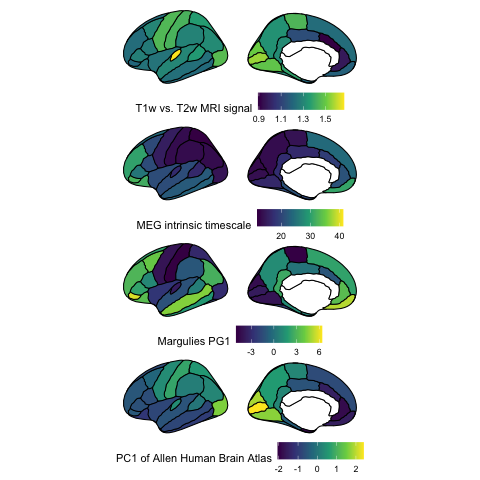

In [13]:
%%R -i hierarchy_dk_neuromaps_res_hemi_avg_sig

all_ggseg_plots_list <- list()

for (desc in unique(hierarchy_dk_neuromaps_res_hemi_avg_sig$Description)) {
      desc_p <- hierarchy_dk_neuromaps_res_hemi_avg_sig %>%
            filter(Description==desc) %>% 
            mutate(label = glue("lh_{Base_Region}")) %>%
            left_join(., as_tibble(dk)) %>%
            ggseg(atlas = dk, mapping = aes(fill = Value),
                  position = "stacked", colour = "black", hemisphere="left",
                  linewidth=0.5) +
            theme_void() +
            labs(fill = desc) +
            theme(plot.title = element_blank(),
                  legend.position = "bottom") +
            scale_fill_viridis_c(na.value = "white")

      all_ggseg_plots_list[[desc]] <- desc_p
}

wrap_plots(all_ggseg_plots_list, ncol=1)
# ggsave("../plots/neuromaps_corrs/Pearson_vs_hierarchy_ggseg_res.svg", width=4, height=6, dpi=300, units="in")


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The dot-dot notation (`..r.label..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(r.label)` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 

R[write to console]: 2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 4: The following aesthetics were dropped 

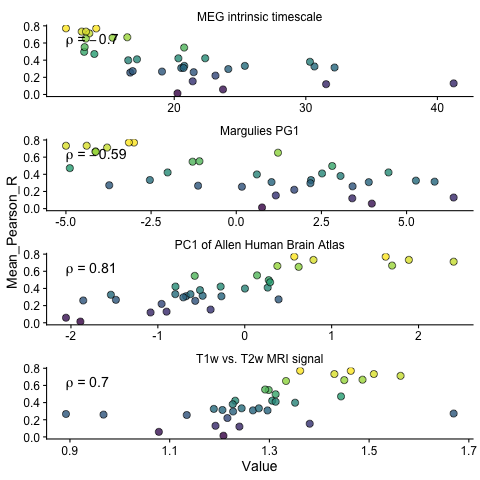

In [14]:
%%R -i hierarchy_neuromaps_vs_pearson_hemi_avg_sig

hierarchy_neuromaps_vs_pearson_hemi_avg_sig %>% 
    ggplot(data=., mapping=aes(x=Value, y=Mean_Pearson_R, fill=Mean_Pearson_R)) +
    geom_point(shape=21, color='black', size=3, alpha=0.8) +
    # Facet wrap but repeat axis titles for each facet
    facet_wrap(Description ~ ., scales="free", ncol=1, axis.labels = 'all') +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
    theme(legend.position='none') +
    scale_fill_viridis_c() +
    theme(strip.background = element_blank())
# ggsave("../plots/neuromaps_corrs/Hierarchy_maps_with_pearson_correlations_scatters.svg", width=2.25, height=6, dpi=300, units="in")

## Spin test to evaluate statistical significance

In [18]:
# Loop through each atlas, extract the values in Desikan-Killiany space, and create a dataframe
spin_test_neuromaps_res_list = []
nm_atlas_df = pd.read_csv('../data/hierarchy_neuromaps_atlases.csv')

# Convert the DK atlas to gifti format
dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

# Fit a Parcellator object
dk_parc = Parcellater(dk_gifti, 'fsaverage', resampling_target='parcellation')

for i, row in nm_atlas_df.iterrows():
    this_row_category = row['Category']
    this_row_desc = row['Description']
    source, desc, space, den = row['Filename'].split('-')

    print(f"Fetching {source} {desc} {space} {den}")
    this_atlas_data = fetch_annotation(source=source, desc=desc, space=space, 
                                        den=den, data_dir=Path("/Users/abry4213/neuromaps-data"))

    # Extract this atlas' values in Desikan-Killiany space
    parc_iter = deepcopy(dk_parc)
    this_atlas_data_in_dk = parc_iter.fit_transform(this_atlas_data, space)

    # Rotate 10 times as start
    rotated = nulls.alexander_bloch(this_atlas_data_in_dk, atlas='fslr', density='164k',
                                    n_perm=10000, seed=127, parcellation=dk_gifti)

    map_spearman_R, map_p_val = stats.compare_images(this_atlas_data_in_dk, mean_pearson_HoFC_dk_brain['value'].values, nulls=rotated, metric='spearmanr')

    # Create a dataframe
    this_map_spin_test_res = pd.DataFrame({'Category': this_row_category,
                                            'Description': this_row_desc,
                                            'Spin_Test_Correlation_to_Pearson_HoFC': map_spearman_R,
                                            'Spin_Test_p_value': map_p_val},
                                            index=[0])

    # Append to the list
    spin_test_neuromaps_res_list.append(this_map_spin_test_res)

# Concatenate all the dataframes
spin_test_neuromaps_res = pd.concat(spin_test_neuromaps_res_list)
spin_test_neuromaps_res

Fetching hcps1200 myelinmap fsLR 32k

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    
Fetching abagen genepc1 fsaverage 10k

[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391

,Category,Description,Spin_Test_Correlation_to_Pearson_HoFC,Spin_Test_p_value
0,Anatomical hierarchy,T1w vs. T2w MRI signal,0.699696,0.0001
0,Transcriptomic hierarchy,PC1 of Allen Human Brain Atlas,0.816618,0.0001
0,Functional hierarchy,Margulies PG1,-0.592932,0.0001
0,Functional hierarchy,MEG intrinsic timescale,-0.714283,0.0001
